The Lotka-Volterra model comprises a system of first-order differential equations that characterize a simple prey-predator relationship in ecology (Lotka, 1932). The following pair of equations describe the change in species population over time:
$$
  \begin{equation}
    \begin{aligned}
      \frac{d}{dt} t H(t) & = \alpha H(t) - \beta H(t) L(t) \\
      \frac{d}{dt} t L(t) & = -\gamma L(t) + \delta H(t) L(t),
    \end{aligned}
  \end{equation}
$$
where $H(t)$ and $L(t)$ represent the prey (hare) and predator (lynx) populations at time $t$, respectively.

The method of inference that we employ for this particular problem utilizes a particle filter and a stochastic optimizer at the end.
The settings we consider for this particular problem are the high noise vs. the low noise setting. There are 8 parameters that we consider in this particular model, namely $\alpha, \beta, \gamma, \delta, \sigma_h, \sigma_l, \tau_h$ and $\tau_l$ where the last four parameters are related to the noise of the observation and of the latent variables. In the stochastic optimization setting we optimize all 8 parameters simultaneously. This implies that we are solving an 8-dimensional optimization problem. The observations for this model are taken from a dataset with $21$ observations. For the stochastic optimization component we test our algorithm with both vanilla gradient descent as well as a well known stochastic optimizer from the machine learning literature, Adam.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax.particle_filter import particle_filter, particle_loglik
from pfjax import proj_data, LotVolModel
import pfjax.sde
from pfjax import stoch_opt, get_sum_lweights

In [2]:
key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1
tau_l = 0.1

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 2
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [3]:
import pandas as pd

data = pd.read_csv("lv_low.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

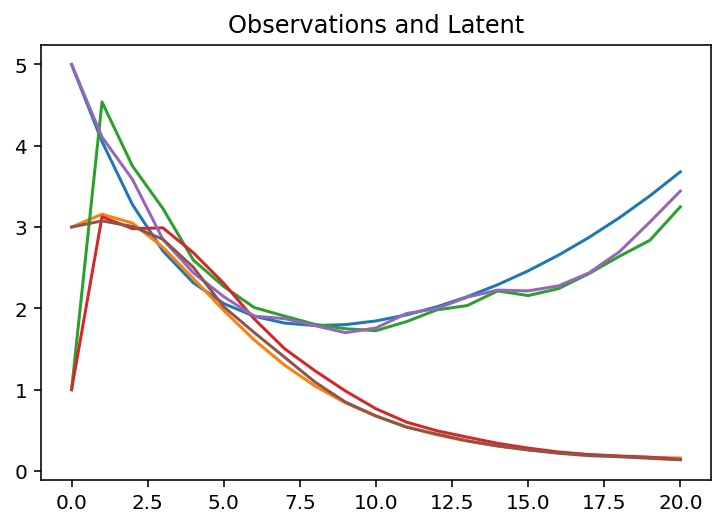

In [4]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent");

## Parameter Estimation with Complete Data

In other words, we estimate $\theta$ as if both $y_{0:T}$ and $x_{0:T}$ were known.  Let's start with projection plots of the complete data (log)likelihood

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

## Parameter Estimation with Particle Filter

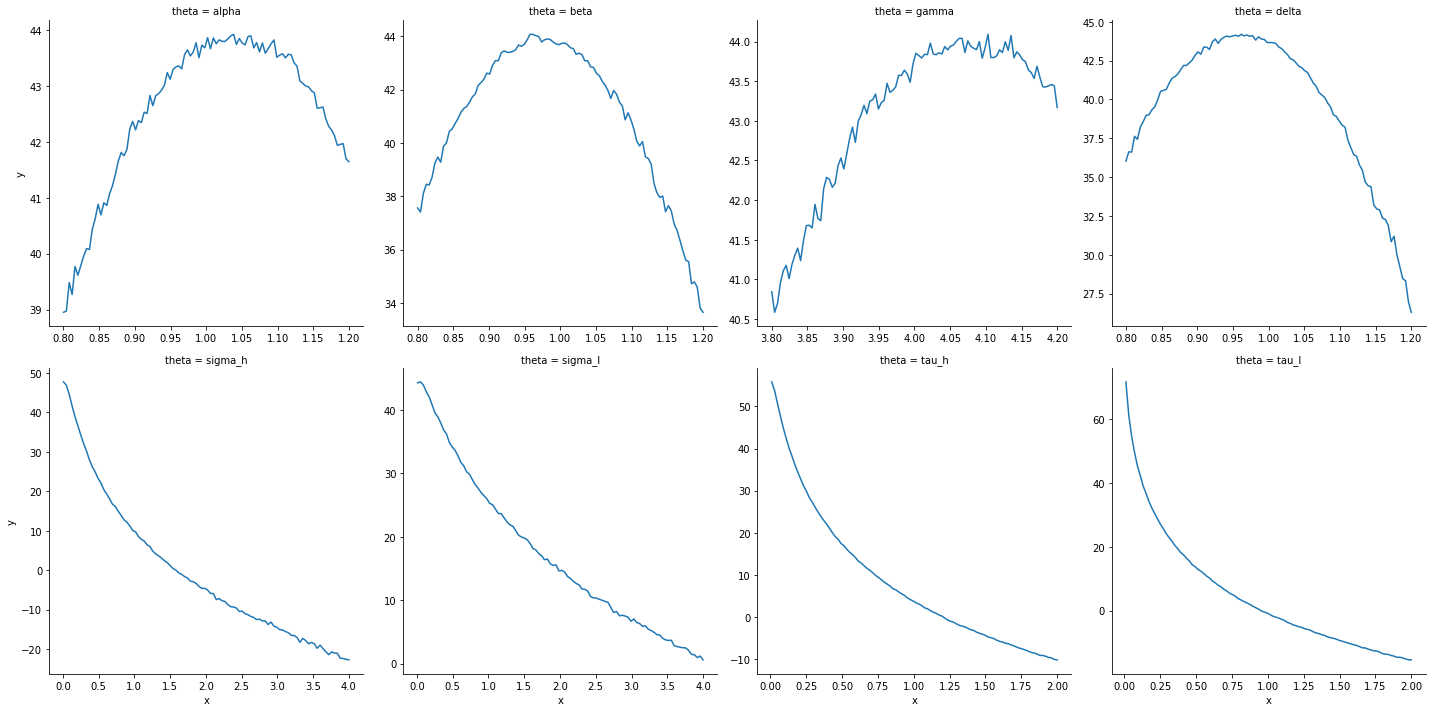

In [5]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

### Stochastic Optimization

For now, we initialize it to be the starting values that were chosen. In addition to this, we also initialize the mask array to be this so that we can verify the results on a one dimensional optimization problem.

In [5]:
from pfjax import stoch_opt, get_sum_lweights

It appears like the value of `sigma_h` and `sigma_l` are extremely important in determining the objective function values.

In [6]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.1, 0.1]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))

/Users/jonny/anaconda3/envs/kaggle/lib/python3.7/site-packages/jax/interpreters/xla.py:842: UserWarning: Some donated buffers were not usable: f32[8]{0}
  ", ".join(unused_donations)))


In [7]:
params

DeviceArray([0.9000013 , 1.1000047 , 3.9000072 , 1.1000047 , 0.13599972,
             0.02000046, 0.17799918, 0.16799931], dtype=float32)

## NRES = 4

In [8]:
dt = 0.1
n_res = 4
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [9]:
data = pd.read_csv("lv_low.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

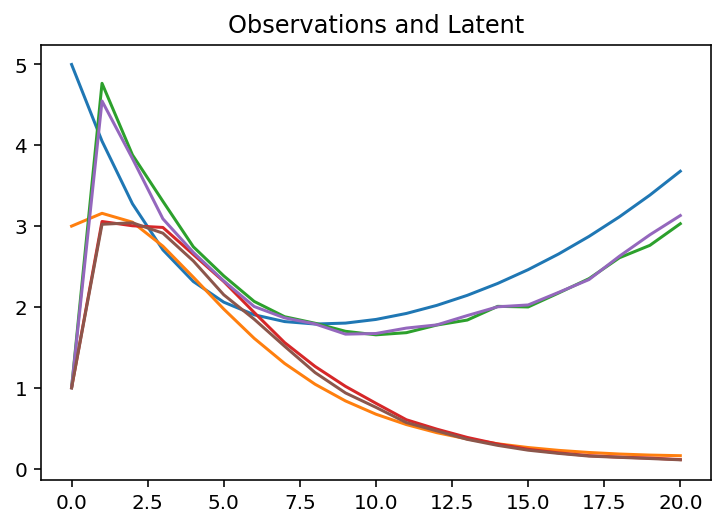

In [10]:
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent");

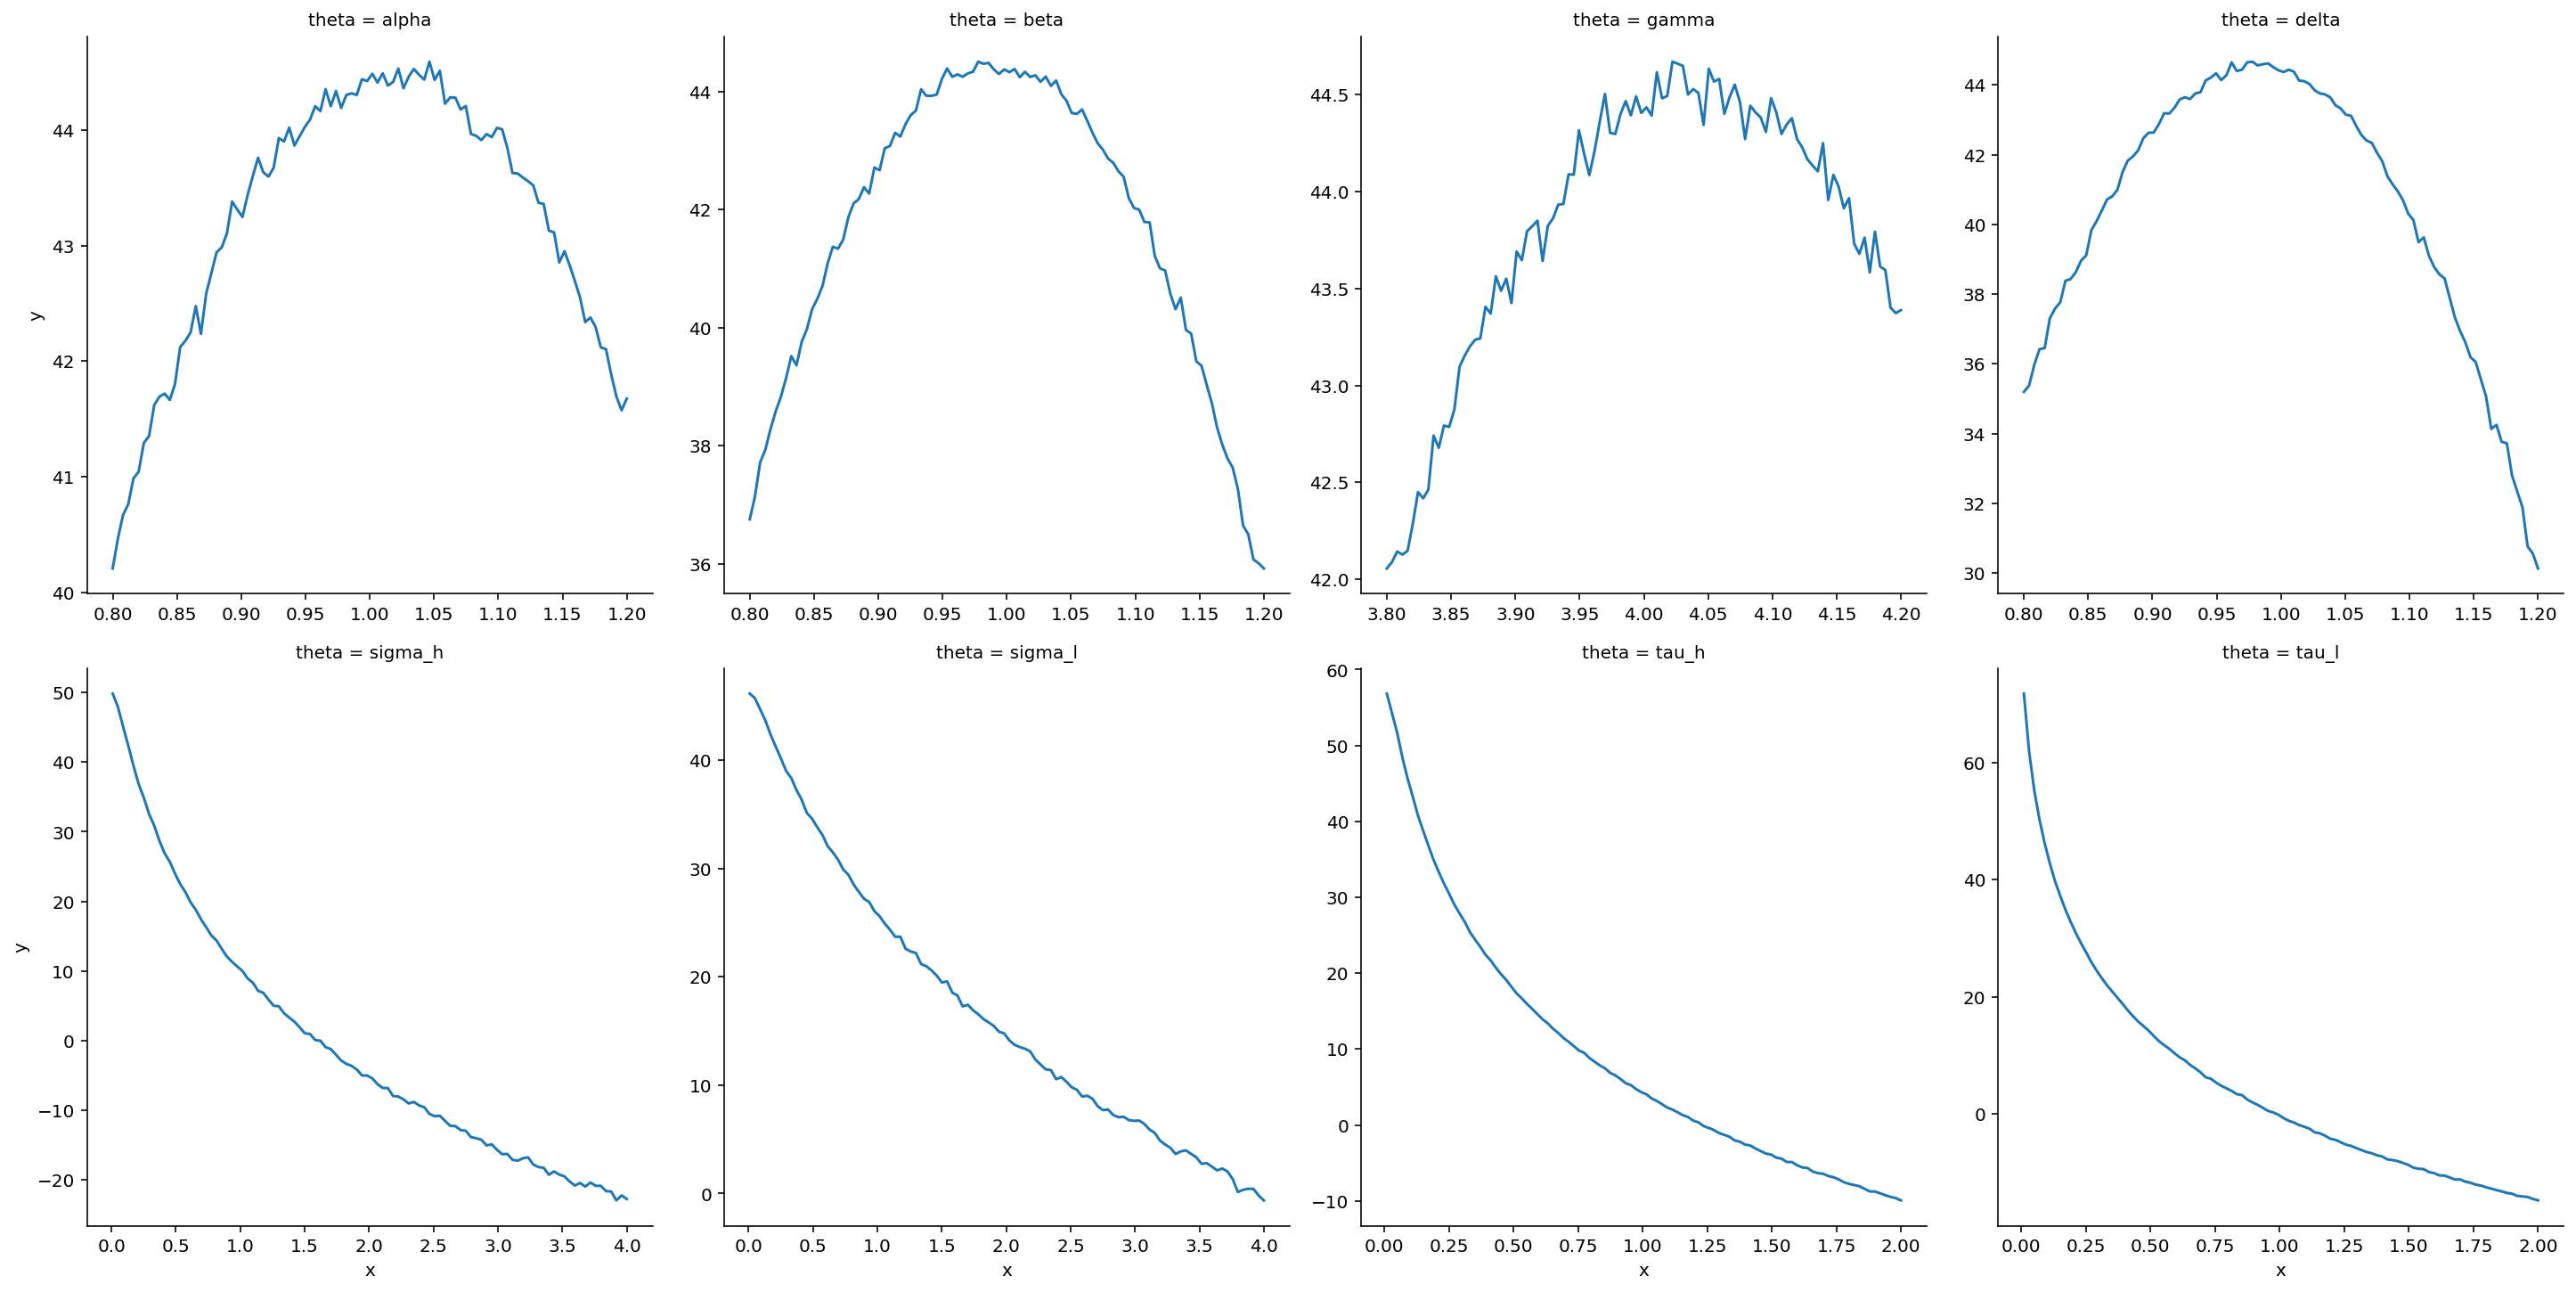

In [18]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000

@jax.jit
def lotvol_pflik(theta):
    temp = particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [25]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.1, 0.1]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
                   mask=np.array([1,1,1,1,1,1,1,1]))

params

DeviceArray([0.9000013 , 1.1000047 , 3.9000072 , 1.1000047 , 0.1999989 ,
             0.07000016, 0.1999989 , 0.1999989 ], dtype=float32)

In [27]:
theta

DeviceArray([1. , 1. , 4. , 1. , 0.1, 0.1, 0.1, 0.1], dtype=float32)

False


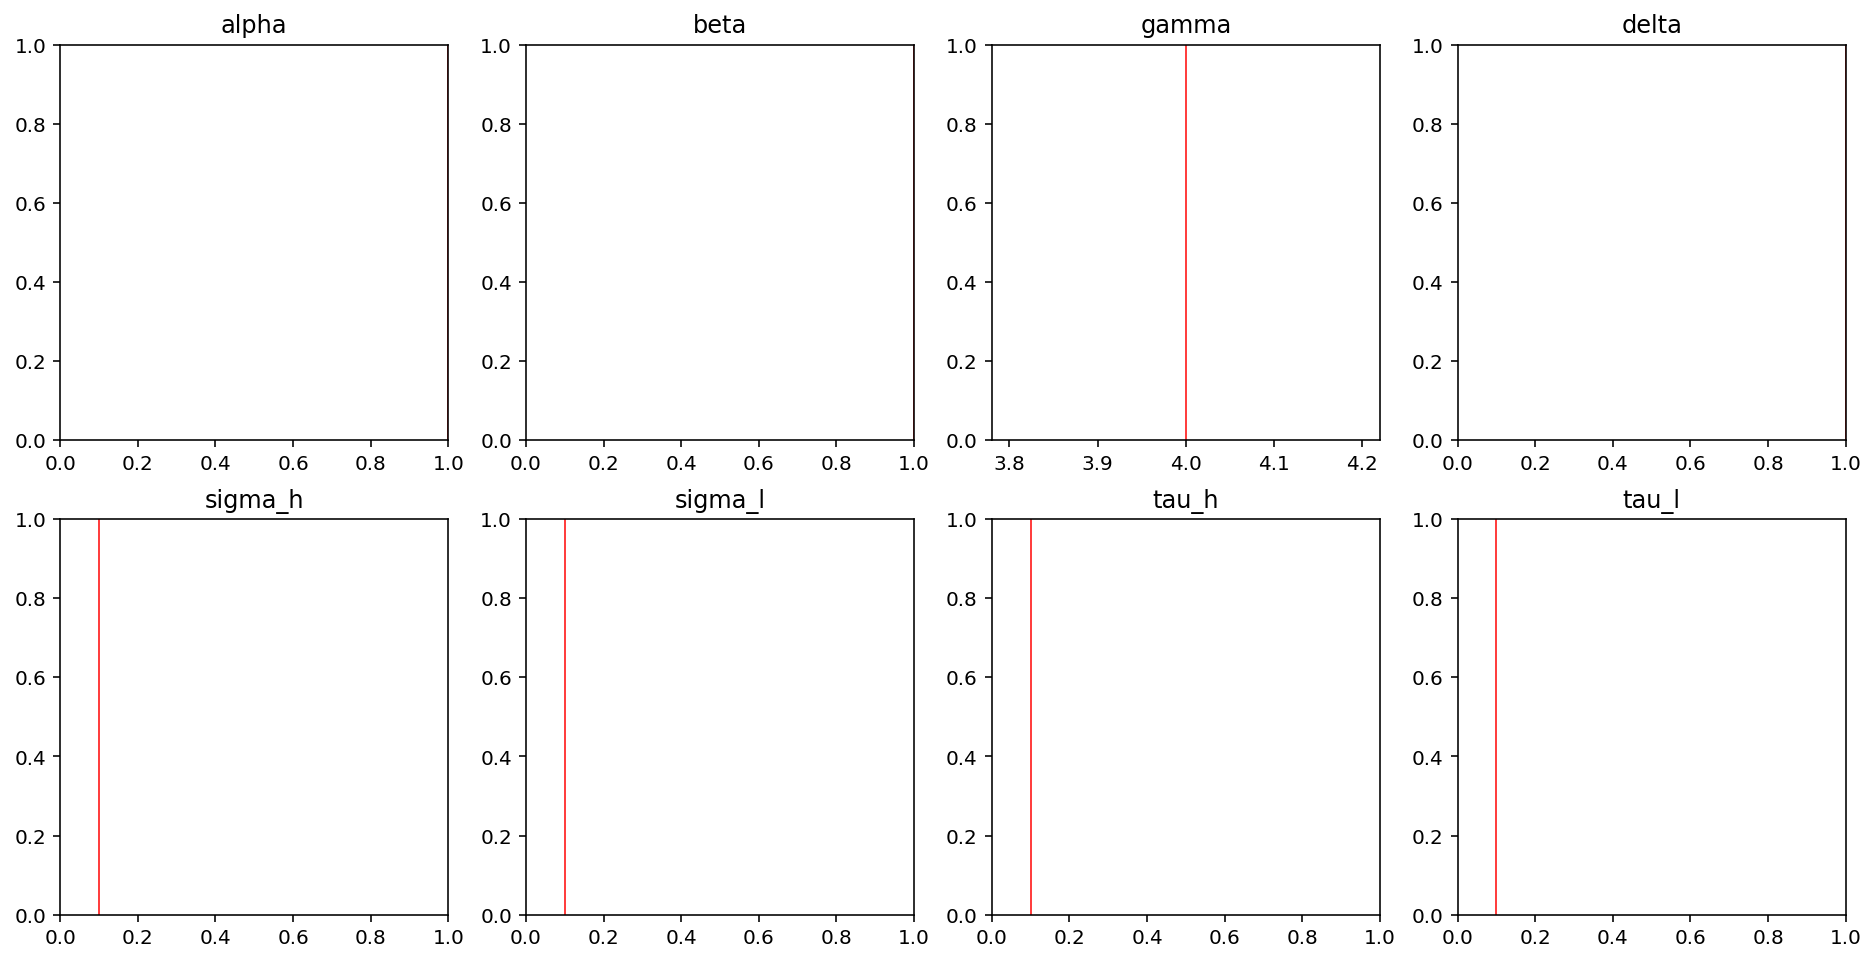

In [28]:
hessian = jax.jacfwd(jax.jacrev(get_sum_lweights))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
hess = hessian(params,
               key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(hess)
print(jnp.all(jnp.linalg.eigvals(-var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]

for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

## NRES = 8

In [30]:
dt = 0.1
n_res = 8
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

_y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [32]:
data = pd.read_csv("lv_low.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

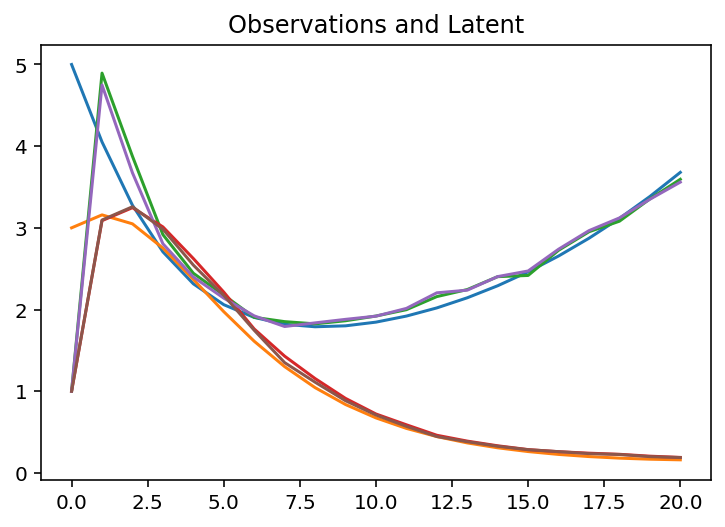

In [34]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent");

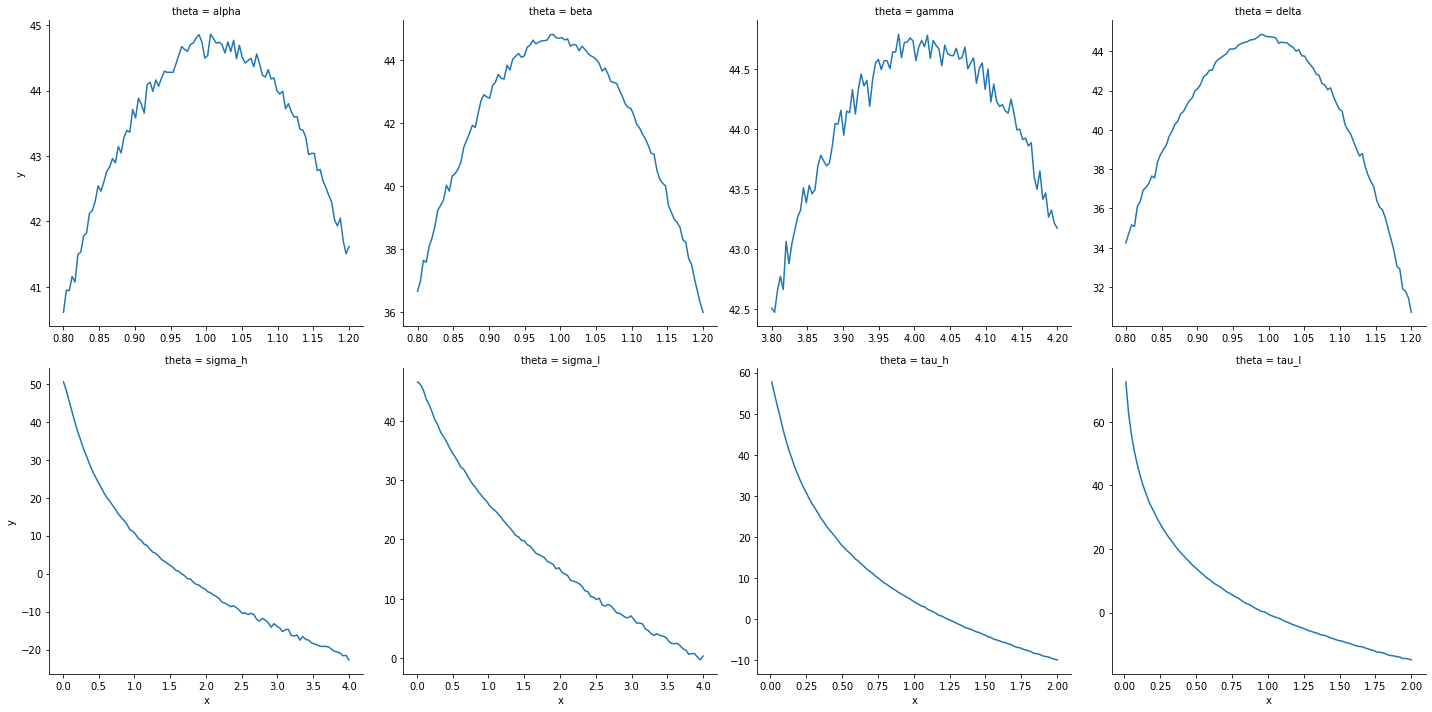

In [18]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [35]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.1, 0.1]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))

/Users/jonny/anaconda3/envs/kaggle/lib/python3.7/site-packages/jax/interpreters/xla.py:842: UserWarning: Some donated buffers were not usable: f32[8]{0}
  ", ".join(unused_donations)))


False


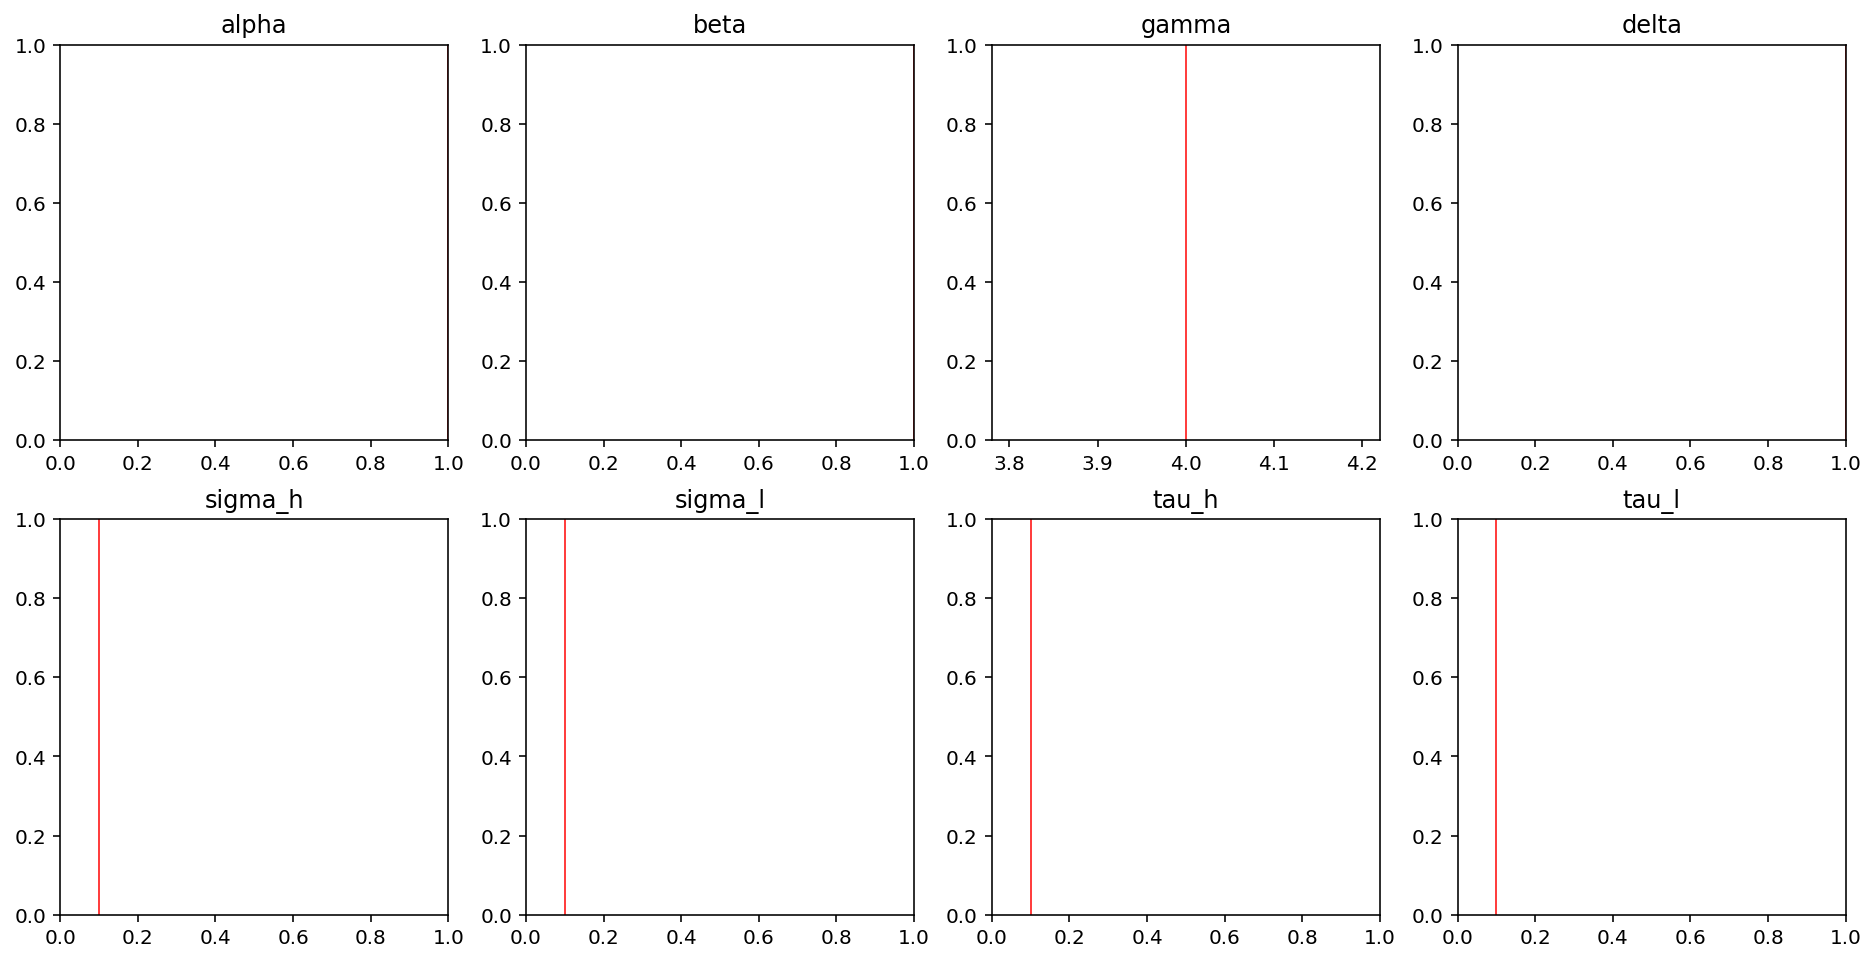

In [36]:
hess = hessian(params,
               key, 
               n_particles=1000, 
               y_meas=y_meas, 
               model=lotvol_model)

theta_hat = params
var_hat = jnp.linalg.inv(hess)
print(jnp.all(jnp.linalg.eigvals(-var_hat) >= 0))

mle_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))# , sharey = True)
param_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]

for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(param_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

In [37]:
round(hess)

DeviceArray([[ -693,   611,  -386,  1013, -1051,  -621,  -213,   -58],
             [  611, -1010,   133,  -446,   963,   328,   288,   -77],
             [ -386,   133,  -458,  1166,  -635,  -648,  -192,  -276],
             [ 1013,  -446,  1166, -3048,  1695,  1711,   556,   765],
             [-1051,   963,  -635,  1695, -1664,  -960,  -101,  -112],
             [ -621,   328,  -648,  1711,  -960, -1242,  -275,  -247],
             [ -213,   288,  -192,   556,  -101,  -275,  -148,  -130],
             [  -58,   -77,  -276,   765,  -112,  -247,  -130,    37]],            dtype=int32)

## NRES = 16

In [20]:
dt = 0.1
n_res = 16
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [21]:
data = pd.read_csv("lv_low.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

Text(0.5, 1.0, 'Observations and Latent')

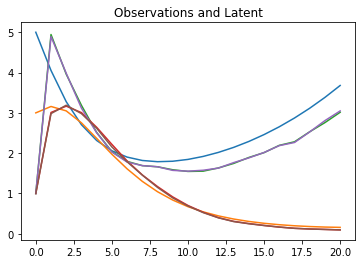

In [22]:
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent")

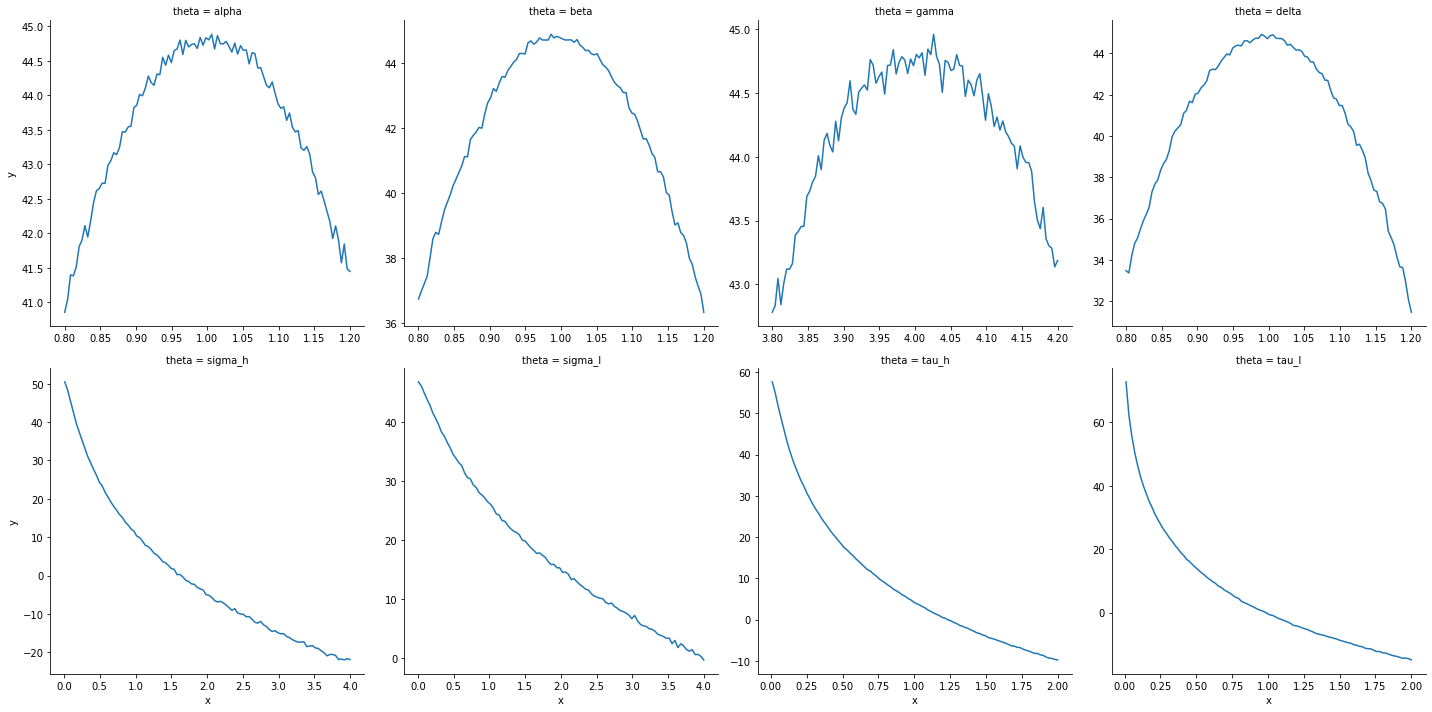

In [23]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [24]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.1, 0.1]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
         mask=np.array([1,1,1,1,1,1,1,1]))

/home/pranavsubramani/workspace/pfjax/venv/lib/python3.8/site-packages/jax/interpreters/xla.py:841: UserWarning: Some donated buffers were not usable: f32[8]{0}
  warn("Some donated buffers were not usable: {}".format(


[0.999 1.001 3.999 1.001 0.101 0.101 0.101 0.101]
[0.998      1.0020001  3.9980001  1.0020001  0.10199999 0.10199999
 0.10199999 0.10199999]
[0.999      1.001      3.999      1.001      0.10299999 0.10299999
 0.10299999 0.10299999]
[0.998      1.         3.9980001  1.0020001  0.10399998 0.10399998
 0.10399998 0.10399998]
[0.999      0.999      3.9970002  1.0030001  0.10499997 0.10499997
 0.10499997 0.10499997]
[0.998      1.         3.9960003  1.0040002  0.10599997 0.10599997
 0.10599997 0.10599997]
[0.99700004 1.001      3.9950004  1.0050002  0.10699996 0.10699996
 0.10699996 0.10699996]
[0.99600005 1.         3.9940004  1.0060003  0.10799996 0.10799996
 0.10799996 0.10799996]
[0.99700004 0.999      3.9930005  1.0070003  0.10899995 0.10899995
 0.10899995 0.10899995]
[0.99600005 0.998      3.9920006  1.0080004  0.10999995 0.10999995
 0.10999995 0.10999995]
[0.99700004 0.99700004 3.9910007  1.0090004  0.11099994 0.11099994
 0.11099994 0.11099994]
[0.998      0.99600005 3.9900007  1.0100

## High Data Experiment

In [25]:
tau_h = 0.25
tau_l = 0.25

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 1
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [26]:
import pandas as pd

data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

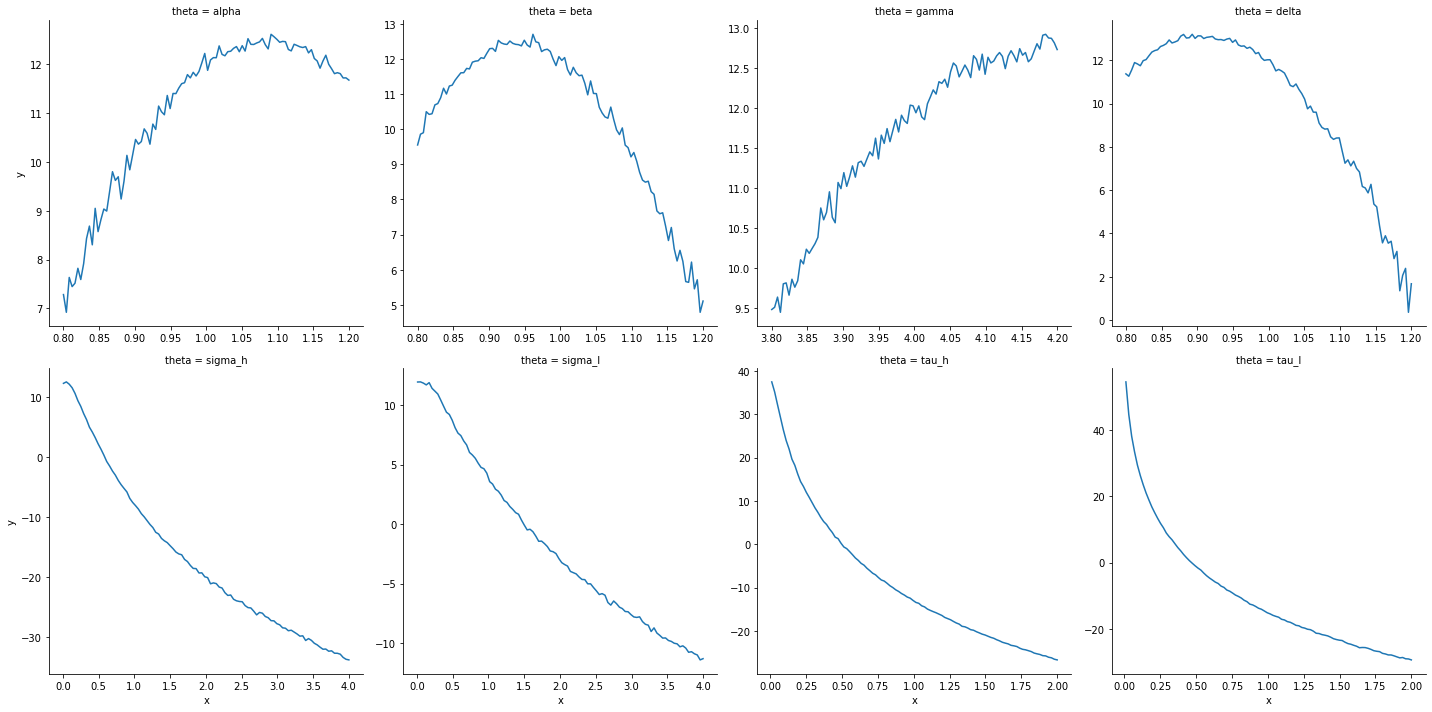

In [27]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [28]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
                   mask=np.array([1,1,1,1,1,1,1,1]))


/home/pranavsubramani/workspace/pfjax/venv/lib/python3.8/site-packages/jax/interpreters/xla.py:841: UserWarning: Some donated buffers were not usable: f32[8]{0}
  warn("Some donated buffers were not usable: {}".format(


[0.999      1.001      3.999      1.001      0.101      0.09900001
 0.251      0.251     ]
[0.998      1.0020001  3.9980001  1.0020001  0.10199999 0.09800001
 0.25199997 0.25199997]
[0.99700004 1.0030001  3.9970002  1.0030001  0.10299999 0.09700002
 0.25299996 0.25299996]
[0.99600005 1.0040002  3.9960003  1.0040002  0.10399998 0.09600002
 0.25399995 0.25399995]
[0.99500006 1.0050002  3.9950004  1.0050002  0.10499997 0.09500003
 0.25499994 0.25499994]
[0.9940001  1.0060003  3.9940004  1.0060003  0.10599997 0.09400003
 0.25599992 0.25599992]
[0.9930001  1.0070003  3.9930005  1.0070003  0.10699996 0.09300004
 0.2569999  0.2569999 ]
[0.9920001  1.0080004  3.9920006  1.0080004  0.10799996 0.09200004
 0.2579999  0.2579999 ]
[0.9910001  1.0090004  3.9910007  1.0090004  0.10899995 0.09100005
 0.25899988 0.25899988]
[0.9900001  1.0100005  3.9900007  1.0100005  0.10999995 0.09000006
 0.25999987 0.25999987]
[0.98900014 1.0110005  3.9890008  1.0110005  0.11099994 0.08900006
 0.26099986 0.26099986]

## NRES = 2

In [ ]:
tau_h = 0.25
tau_l = 0.25

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 2
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [ ]:
import pandas as pd

data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

In [ ]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [ ]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
                   mask=np.array([1,1,1,1,1,1,1,1]))

## NRES = 4

In [ ]:
tau_h = 0.25
tau_l = 0.25

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 4
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [ ]:
import pandas as pd

data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

In [ ]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [ ]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
                   mask=np.array([1,1,1,1,1,1,1,1]))

## NRES = 8

In [ ]:
tau_h = 0.25
tau_l = 0.25

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 8
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [ ]:
import pandas as pd

data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

In [ ]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [ ]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
                   mask=np.array([1,1,1,1,1,1,1,1]))

## NRES = 16

In [ ]:
tau_h = 0.25
tau_l = 0.25

theta = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 8
n_obs = 21
lotvol_model = LotVolModel(dt, n_res) 
# key, subkey = random.split(key)


x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(lotvol_model, key, n_obs, x_init, theta)

In [ ]:
import pandas as pd

data = pd.read_csv("lv_high.csv")
y_meas_1 = data["Trueode.1"].values.reshape(-1, 1)
y_meas_2 = data["Trueode.2"].values.reshape(-1, 1)
y_meas = np.concatenate((y_meas_1, y_meas_2), axis=1)
y_meas = jnp.array(y_meas)

In [ ]:
theta_lims = np.array([[0.8, 1.2], [0.8, 1.2], [3.8, 4.2], [0.8, 1.2], [0.01, 4.], [0.01, 4.], [0.01, 2.], [0.01, 2.]])
theta_names = ["alpha", "beta", "gamma", "delta", "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

# calculate projection plot
n_particles = 1000


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [ ]:
params = stoch_opt(lotvol_model, jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), get_sum_lweights, y_meas, key=key, learning_rate=0.001, iterations=100, n_particles=500,
                   mask=np.array([1,1,1,1,1,1,1,1]))